## 1. Presentación

En el presente notebook se realiza la extracción de información de tweets relacionados con el usuario *TheBridge_Tech*, con el fin de analizar y evaluar los sentimientos con respecto al perfil de la escuela a través de un análisis de datos exploratorio y en función de esa extracción y con un modelo preentrenado, sacar conclusiones y posteriormente proceder a su despliegue en la web.

### 1. Recopilar los **tweets**

In [ ]:
#%pip install git+https://github.com/JustAnotherArchivist/snscrape.git

#actualizar librería snscrape. viene por defecto una desactualizada y hay que hacerlo de forma manual

In [27]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import plotly.express as px
import plotly.figure_factory as ff
import sklearn
import warnings #para ignorar advertencias

#importar librerías necesarias

In [22]:
#definimos el usuario a buscar y el rango de fechas para los parámetros
account = "@TheBridge_Tech"
start_date = "2023-02-13"
end_date = "2023-05-22"

#crear la query
query = f"{account} since:{start_date} until:{end_date}"

#obtener tweets con bucle
tweets = []
for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    tweet_id = tweet.id
    text = tweet.rawContent
    date = tweet.date.strftime('%Y-%m-%d %H:%M:%S')
    author_id = tweet.user.id
    author_name = tweet.user.displayname
    author_username = tweet.user.username
    retweets = tweet.retweetCount
    replies = tweet.replyCount
    likes = tweet.likeCount
    quotes = tweet.quoteCount
    

    tweets.append([tweet_id, text, date, author_id, author_name, author_username, retweets, replies, likes, quotes])

    #romper el bucle cuando alcance un exceso de tweets
    if len(tweets) >= 200:
        break

Stopping after 20 empty pages


In [23]:
#crear el dataframe a partir de los datos que se solicitan
columns = ["ID", "Text", "Date", "Author ID", "Author Name", "Author Username", "Retweets", "Replies", "Likes", "Quotes"]
tweets_df = pd.DataFrame(tweets, columns=columns)

In [4]:
#visualizamos el df
tweets_df.head()

,ID,Text,Date,Author ID,Author Name,Author Username,Retweets,Replies,Likes,Quotes
0,1659514560200470559,Ayer visitamos a los alumnos de @TheBridge_Tec...,2023-05-19 11:01:18,987047282,A3Sec,a3sec,1,0,3,1
1,1659136842854219776,¿Qué hacían nuestros alumni antes del #bootcam...,2023-05-18 10:00:23,1162694149956603904,The Bridge,TheBridge_Tech,0,0,0,0
2,1658825158994403329,"#MLMonitoring and #Observability, mar, 23 may ...",2023-05-17 13:21:52,41545659,Mario Lopez de Avila,nodosenlared,1,0,3,0
3,1658791064306688002,Nos colamos en el campus de #Bilbao para descu...,2023-05-17 11:06:23,1162694149956603904,The Bridge,TheBridge_Tech,1,0,2,0
4,1658430987368386566,Así es el #bootcamp de #UXUIProductDesign que ...,2023-05-16 11:15:34,1162694149956603904,The Bridge,TheBridge_Tech,1,0,3,0


In [7]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               143 non-null    int64 
 1   Text             143 non-null    object
 2   Date             143 non-null    object
 3   Author ID        143 non-null    int64 
 4   Author Name      143 non-null    object
 5   Author Username  143 non-null    object
 6   Retweets         143 non-null    int64 
 7   Replies          143 non-null    int64 
 8   Likes            143 non-null    int64 
 9   Quotes           143 non-null    int64 
dtypes: int64(6), object(4)
memory usage: 11.3+ KB


In [8]:
tweets_df.describe()

,ID,Author ID,Retweets,Replies,Likes,Quotes
count,1.430000e+02,1.430000e+02,143.000000,143.000000,143.000000,143.000000
mean,1.640923e+18,7.433382e+17,1.468531,0.349650,3.510490,0.153846
std,9.297728e+15,5.770250e+17,2.666443,0.674054,4.871398,0.521478
min,1.625127e+18,7.154412e+06,0.000000,0.000000,0.000000,0.000000
25%,1.634147e+18,1.003872e+09,0.000000,0.000000,1.000000,0.000000
50%,1.638579e+18,9.365398e+17,1.000000,0.000000,2.000000,0.000000
75%,1.648301e+18,1.162694e+18,2.000000,1.000000,4.000000,0.000000
max,1.659515e+18,1.613114e+18,25.000000,4.000000,39.000000,4.000000


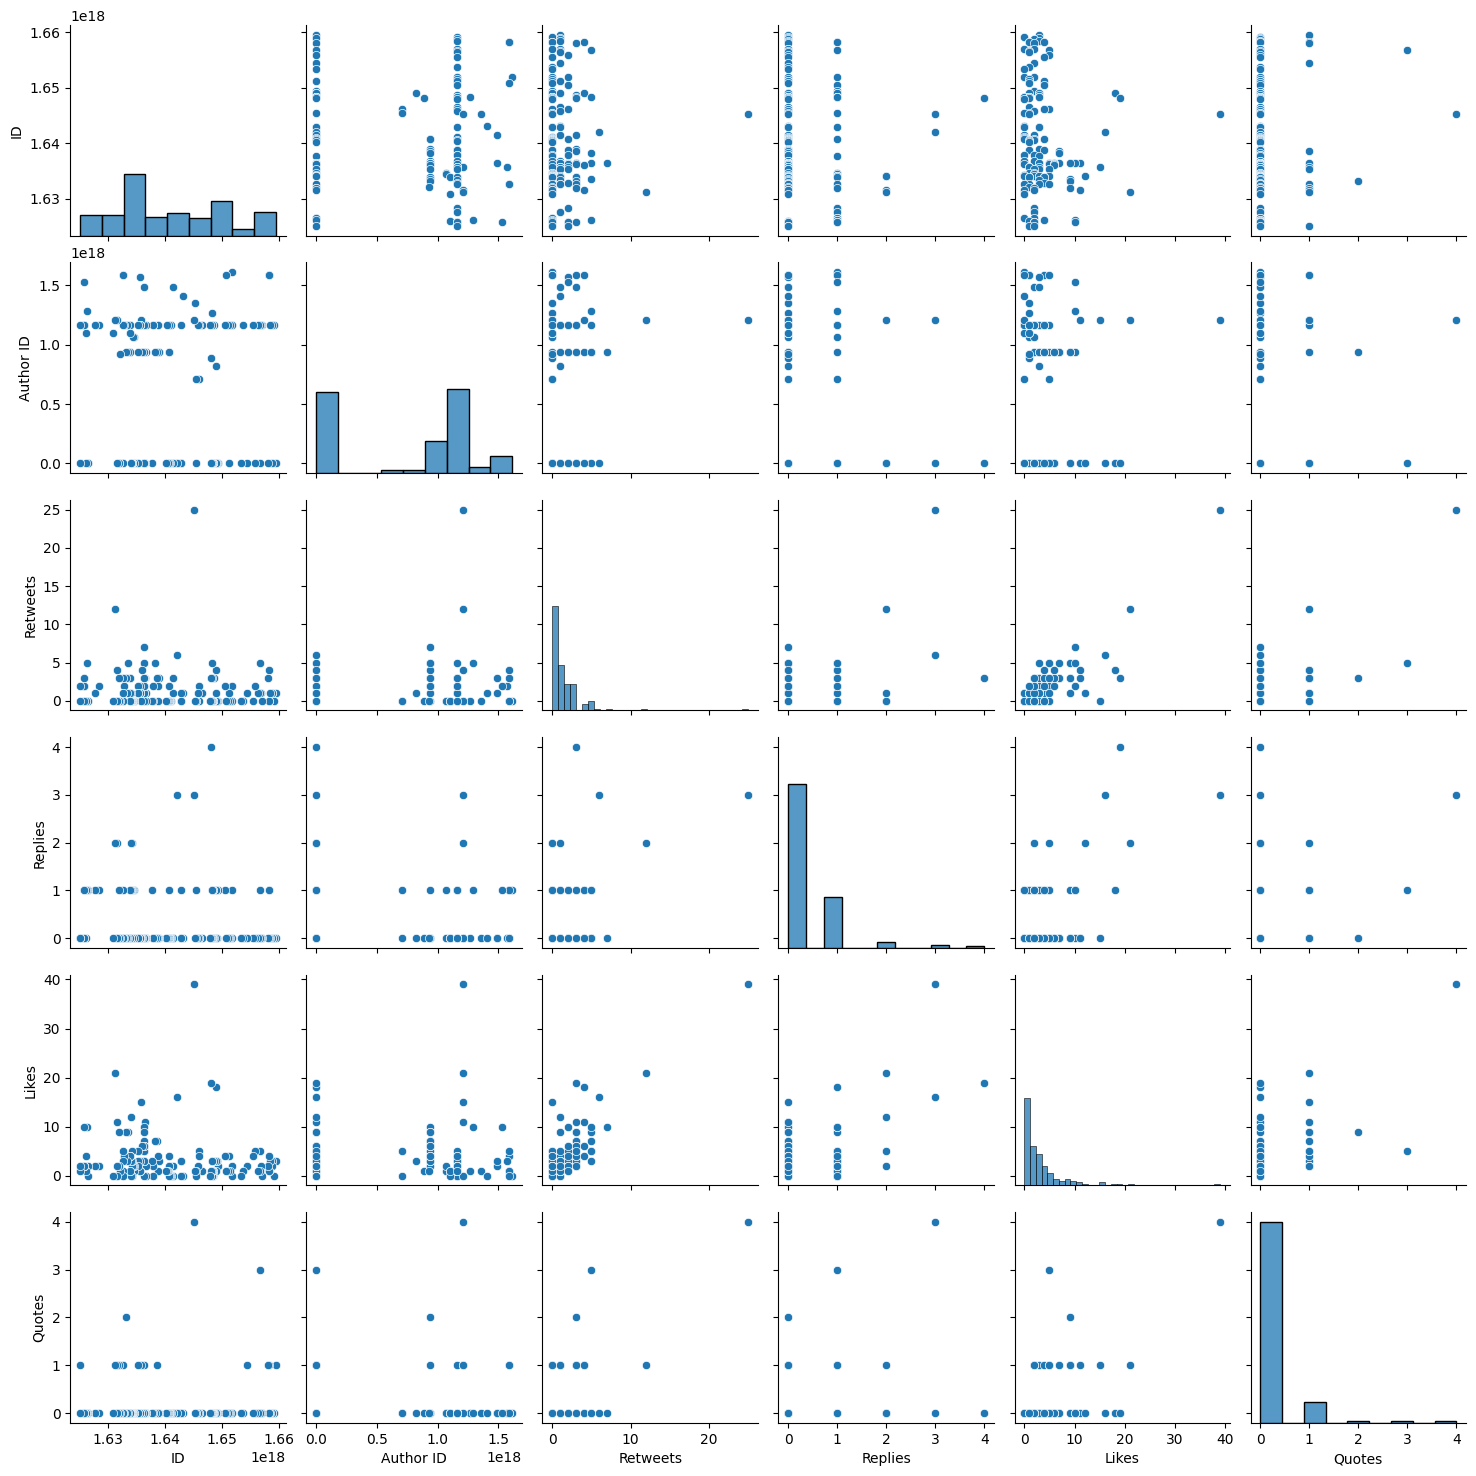

In [9]:
sns.pairplot(tweets_df);
#no hay una relación entre las variables

### 2. Base de datos SQL

In [5]:
#primero creo mi base de datos y le doy nombre
conn = sqlite3.connect('tuiterdb.db')

In [20]:
#creo el cursor para ejecutar los comandos
cursor = conn.cursor()

In [21]:
#tabla 1 · usuarios
cursor.execute('''
    CREATE TABLE usuarios (
        id INTEGER,
        nombre TEXT,
        nombre_usuario TEXT
    )
''')

In [22]:
#tabla 2 · tweets
cursor.execute('''
    CREATE TABLE tweets (
        id INTEGER PRIMARY KEY,
        contenido TEXT,
        fecha_publicacion TEXT,
        usuario_id INTEGER,
        retweets INTEGER,
        replies INTEGER,
        likes INTEGER,
        quotes INTEGER,
        FOREIGN KEY (usuario_id) REFERENCES usuarios (id)
    )
''')

In [23]:
#bucle para llenar mis 2 tablas de mi database con los datos de mi dataframe
for _, row in tweets_df.iterrows():
    tweet_data = [
        row['ID'],
        row['Text'],
        row['Date'],
        row['Author ID'],
        row['Retweets'],
        row['Replies'],
        row['Likes'],
        row['Quotes']
    ]
    author_data = [
        row['Author ID'],
        row['Author Name'],
        row['Author Username']
    ]

    cursor.execute('INSERT INTO tweets VALUES (?, ?, ?, ?, ?, ?, ?, ?)', tweet_data)
    cursor.execute('INSERT INTO usuarios VALUES (?, ?, ?)', author_data)

In [6]:
#guardar y cerrar
conn.commit()
conn.close()

### 3. Análisis de datos exploratorio

3.1-    En primer lugar analizaremos el tweet con mayor repercusión social en el rango de fechas comprendido entre 13-febrero y 22-mayo de este mismo año (2023):

In [29]:
tweets_df.Retweets.max()
#accedemos al número más alto de retweets que podamos encontrar en el df

25

In [33]:
#hacemos lo mismo con likes, replies y quotes para mirar cuáles son los que han tenido más interacciones
print('El tweet con mayor número de respuestas, tiene: ',tweets_df.Replies.max(),'respuestas')
print('El tweet con mayor número de likes, tiene: ',tweets_df.Likes.max(),'likes')
print('El tweet con mayor número de citas, tiene: ',tweets_df.Quotes.max(),'citas')

El tweet con mayor número de respuestas, tiene:  4 respuestas
El tweet con mayor número de likes, tiene:  39 likes
El tweet con mayor número de citas, tiene:  4 citas


In [36]:
#buscamos los tuits que cumplen con las métricas que tenemos de los números más altos

tweets_df[(tweets_df.Retweets == 25) | (tweets_df.Replies == 4) | (tweets_df.Likes == 39) | (tweets_df.Quotes == 4)]

,ID,Text,Date,Author ID,Author Name,Author Username,Retweets,Replies,Likes,Quotes
42,1648038694387871801,Untagged Day - El evento de analítica digital ...,2023-04-17 19:00:18,20979418,Iñaki Gorostiza,hello_google,3,4,19,0
51,1645201576217157637,Para reactivarse!!!\nTenemos Meetup este marte...,2023-04-09 23:06:36,1207228796593745920,Decentralized ₿丰⚡,decentralized_b,25,3,39,4


Observamos que hay dos tweets con buena repercusión, pero sin duda es el segundo el que ha obtenido más interacciones por parte de los usuarios. El tweet dice: 

In [38]:
tweets_df['Text'].iloc[51]

'Para reactivarse!!!\nTenemos Meetup este martes 11 de abril a las 19:00 en @TheBridge_Tech\n\n@dev7ba nos hablará sobre la mempool!!\nCharla para todo el mundo, sepas o no sobre #Bitcoin \n\n@GaboHBeaumont @kilrau @libertariadora @olya_borderless\nhttps://t.co/bHzpDduIRo\n\nSe agradece RT'

Habla de una charla sobre criptomonedas en Abril, que tuvo bastante buena aceptación

3.2 - Vamos a buscar ahora cuál es el usuario que más menciona a la escuela:

In [39]:
tweets_df['Author Username'].value_counts()

Author Username
TheBridge_Tech     45
DatabeerSVQ        17
nodosenlared        9
ESOLIUPO            6
decentralized_b     5
ToniDorta           4
espacio_RES         4
hello_google        4
PauMugarra          4
turoninos           3
my_tech_plan        3
Godivaciones        3
milmadrid_          2
libertariadora      2
alexaom6_           2
carlosmdh           2
vizca75             2
joobid              2
Metricool_es        2
jorgegrev           2
EDEMempresarios     2
MISTERINCGNITA1     2
RoccoLozano         1
detailorg           1
rperezmarco         1
Recuenco            1
42UrdulizFTef       1
a3sec               1
Delachica           1
luismesalas         1
Cyber_Madrid        1
gzuuus              1
UbaldoHervas        1
AlejoPietraSEO      1
BBKnetwork          1
ProductoActual1     1
Madrid4Refugees     1
BitcoinTuesday_     1
Name: count, dtype: int64

Observamos que el que más se menciona es la misma escuela, probablemente en función de respuestas a tweets en los que ha sido mencionado y al responder, se responde a sí mismo para mantener intacto el hilo de respuestas y que cualquiera pueda seguirlas de una forma ordenada. 

El usuario inmediatamente siguiente que más interactúa con la escuela es **DatabeerSVQ**. Vamos a ver sus tweets:

In [40]:
tweets_df[tweets_df['Author Username'] == 'DatabeerSVQ']

,ID,Text,Date,Author ID,Author Name,Author Username,Retweets,Replies,Likes,Quotes
62,1640759403455426560,¡En 5 minutos abrimos las puertas de @sngular ...,2023-03-28 16:55:00,936539844079218688,DatabeerSVQ,DatabeerSVQ,0,1,2,0
63,1640743327145291777,El jueves pasado disfrutamos mucho de la edici...,2023-03-28 15:51:07,936539844079218688,DatabeerSVQ,DatabeerSVQ,2,0,4,0
68,1638948723483975680,¡Que ya estamos preparando la cervecita fresqu...,2023-03-23 17:00:00,936539844079218688,DatabeerSVQ,DatabeerSVQ,3,0,3,0
71,1638578785963606016,¡Qué ganas de #DatabeerSVQ19! Ya está aquí a p...,2023-03-22 16:30:00,936539844079218688,DatabeerSVQ,DatabeerSVQ,3,0,7,1
72,1638212188832759808,"#Dataholics, este jueves #DatabeerSVQ19, con c...",2023-03-21 16:13:16,936539844079218688,DatabeerSVQ,DatabeerSVQ,5,0,7,0
76,1636774407862353920,"#Dataholic, ¿conoces a nuestros colaboradores?...",2023-03-17 17:00:03,936539844079218688,DatabeerSVQ,DatabeerSVQ,1,0,2,0
79,1636422407480066050,"@jrtexeira, co-fundador de @MagmaSevilla, nos ...",2023-03-16 17:41:19,936539844079218688,DatabeerSVQ,DatabeerSVQ,2,0,3,0
80,1636421459831603216,"Pedro Albarracín, Data Scientist, nos hablará ...",2023-03-16 17:37:33,936539844079218688,DatabeerSVQ,DatabeerSVQ,3,0,7,0
81,1636420575735296000,"Sergio Soto, Software Engineer, nos hablará de...",2023-03-16 17:34:03,936539844079218688,DatabeerSVQ,DatabeerSVQ,5,0,5,0
82,1636419888754442242,"Emilio Fuentes, analista en CNMC, nos contará ...",2023-03-16 17:31:19,936539844079218688,DatabeerSVQ,DatabeerSVQ,3,0,6,0


Como podemos observar, la mayoría de tweets hacen alusión a las colaboraciones que hacen la escuela y la organización a la hora de montar eventos unidos para charlar sobre la disciplina de Data Science al mismo tiempo que tomar algún refrigerio, estos se encuentran específicamente en la capital andaluza. 

3.3 - Los meses en los que se concentra la mayor actividad de menciones y comunicación con respecto a la escuela los sacaremos ahora mismo: 

In [42]:
tweets_df['Date'].dtype
#primero comprobamos su tipo y la convertimos a datetime

dtype('O')

In [47]:
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], format="%Y-%m-%d %H:%M:%S")
#comprobamos el tipo
tweets_df['Date'].dtype

dtype('<M8[ns]')

In [48]:
tweets_df['Date'].dt.month.value_counts()
#aquí comprobamos cuántas veces aparecen tweets según el mes

Date
3    73
4    38
5    19
2    13
Name: count, dtype: int64

Como podemos observar, el mes en el que ha habido mayor interacciones con la escuela ha sido justo tras empezar el intake del año 2023, en el mes de marzo. Después han ido decayendo las comunicaciones por esta red social en el resto de meses, lo graficamos: 

In [ ]:
#guardamos en una variable el conteo de los meses
counts = tweets_df['Date'].dt.month.value_counts()

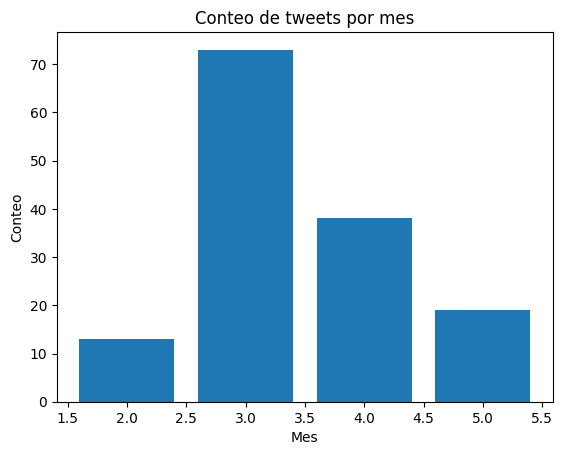

In [59]:
#creamos la gráfica
plt.bar(counts.index, counts.values);

plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.title('Conteo de tweets por mes')

plt.show()

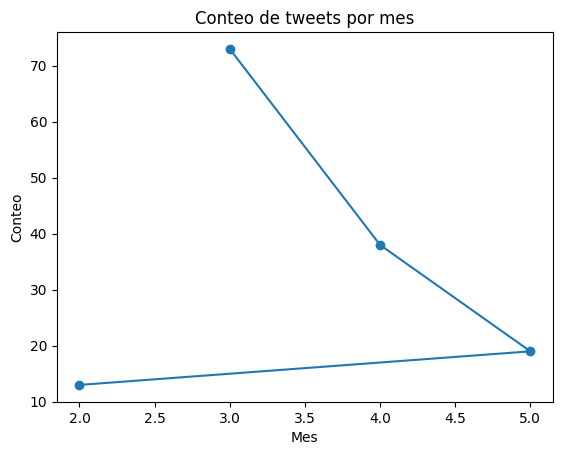

In [61]:
#gráfico de líneas
plt.plot(counts.index, counts.values, marker='o')

plt.xlabel('Mes')
plt.ylabel('Conteo')
plt.title('Conteo de tweets por mes')

plt.show()

3.4 - Otro de los factores importantes a analizar es cuáles son las palabras más utilizadas a la hora de revisar los tweets que se dirigen hacia la escuela y sus menciones, esto nos puede dar información relevante sobre el sentimiento de los usuarios hacia la marca:

In [66]:
palabras_contadas = []

#bucle para almacenar las palabras en mi lista vacía 

for tweet in tweets_df['Text']:
    palabras = tweet.split()
    conteo = Counter(palabras)
    palabras_contadas.extend(conteo.items())

#ordenar la lista por orden para ver las más habituales
palabras_contadas = sorted(palabras_contadas, key=lambda x: x[1], reverse=True)

In [69]:
palabras_contadas

[('a', 5),
 ('de', 5),
 ('de', 4),
 ('👉', 4),
 ('de', 4),
 ('de', 4),
 ('de', 4),
 ('la', 4),
 ('el', 4),
 ('a', 4),
 ('por', 4),
 ('en', 4),
 ('de', 4),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('&amp;', 3),
 ('de', 3),
 ('en', 3),
 ('en', 3),
 ('de', 3),
 ('en', 3),
 ('de', 3),
 ('y', 3),
 ('de', 3),
 ('de', 3),
 ('y', 3),
 ('el', 3),
 ('en', 3),
 ('el', 3),
 ('la', 3),
 ('en', 3),
 ('el', 3),
 ('el', 3),
 ('de', 3),
 ('en', 3),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('de', 3),
 ('the', 3),
 ('la', 3),
 ('de', 3),
 ('de', 3),
 ('a', 3),
 ('a', 3),
 ('de', 3),
 ('de', 3),
 ('lo', 3),
 ('que', 3),
 ('la', 3),
 ('y', 3),
 ('en', 3),
 ('de', 3),
 ('en', 3),
 ('de', 3),
 ('de', 3),
 ('un', 3),
 ('en', 2),
 ('y', 2),
 ('el', 2),
 ('de', 2),
 ('su', 2),
 ('en', 2),
 ('y', 2),
 ('el', 2),
 ('en', 2),
 ('qué', 2),
 ('de', 2),
 ('y', 2),
 ('de', 2),
 ('y', 2),
 ('Entradas', 2),
 ('at', 2),
 ('a', 2),
 ('en', 2),
 ('en', 2),
 ('y', 2),
 ('y', 2),
 ('con', 2),
 ('las', 2),
 ('lo', 2),
 ('d

Como vemos las palabras más empleadas no son ninguna en especial, en su mayoría conectores, nexos y determinantes que funcionan para dar sentido a las oraciones, pero no hay una palabra muy utilizada como tal que nos dé información específica.

3.5.- Vamos a centrarnos en las métricas de los tweets y a buscar correlación matemática entre ellas: 

In [17]:
#en primer lugar sacamos una matriz de correlación del dataframe sobre una tabla
correlation_matrix = tweets_df[['Likes', 'Retweets', 'Quotes', 'Replies']].corr()

A continuación observamos las correlaciones matemáticas que hay entre las métricas de los tweets, como sabemos, la correlación sólo mide la relación lineal entre las variables y no implica causalidad. 

In [18]:
correlation_matrix

,Likes,Retweets,Quotes,Replies
Likes,1.000000,0.822879,0.572948,0.530167
Retweets,0.822879,1.000000,0.631514,0.358802
Quotes,0.572948,0.631514,1.000000,0.246580
Replies,0.530167,0.358802,0.246580,1.000000


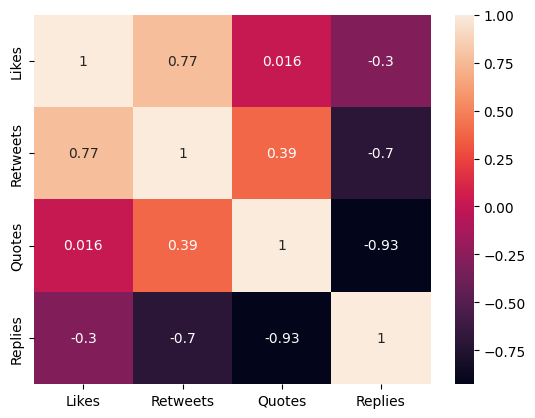

In [20]:
sns.heatmap(correlation_matrix.corr(), annot=True);

Lo que podemos observar es una buena correlación entre **Retweets** y **Likes**, lo que entendemos por el uso de la plataforma habitual es que los perfiles que dan me gusta, suelen además compartir el contenido a sus propios seguidores con un *retweet*, como una forma de certificar de doble forma que una publicación determinada ha sido de su agrado. 


In [47]:
#hacemos un heatmap interactivo con plotly
fig = px.imshow(correlation_matrix)
fig.write_html('correlation_plotly.html')

Otra de las relaciones que llama la atención es la que sucede entre las citas (*quotes*) y las respuestas a los tweets. Cuando un usuario cita el tweet, lo comparte al mismo tiempo que puede hacer un comentario sobre el contenido en su propio perfil, por lo que citando se ahorra responder al usuario de la publicación original de forma directa, sino que lo comparte directamente como parte de su *timeline*. 

In [48]:
#haremos un scatterplot interactivo con plotly
columns = ['Likes', 'Retweets', 'Quotes', 'Replies']

fig = ff.create_scatterplotmatrix(tweets_df[columns], diag='histogram', height=800, width=800)
fig.write_html('scatter_plotly.html')

Aunque hemos sacado bastantes datos analizando nuestras métricas, aún se puede exprimir algo más:

In [4]:
#para seguir analizando, separamos las columnas de las métricas en una variable
metrics = tweets_df.iloc[:, 6:10]

In [32]:
#lo metemos en un propio df que reúne una suma de los valores
metrics_df = {
    'retw_sum' : [metrics['Retweets'].sum()],
    'rep_sum' : [metrics['Replies'].sum()],
    'like_sum' :[ metrics['Likes'].sum()],
    'quot_sum' : [metrics['Quotes'].sum()],
    'tweets_sum' : [len(tweets_df)]
}

metrics_df = pd.DataFrame(metrics_df)

In [34]:
metrics_df

,retw_sum,rep_sum,like_sum,quot_sum,tweets_sum
0,210,50,503,22,143


Con esto lo que observamos es la tendencia de los usuarios a dar *like* por encima de cualquier otra métrica, incluso doblando la siguiente que tiene por debajo, el *retweet*. Los usuarios prefieren hacer una interacción directa con el perfil que proporciona el contenido, antes que compartirlo con el resto de los seguidores de sus propios perfiles (con un *retweet* o un *quote*). 


Vemos que las respuestas son un número bastante bajo cuando hablamos de un total de 140 tweets dirigidos a la escuela. En cambio el número de *likes* y de *retweets* tiene unas cifras atractivas, puesto que partiendo de un análisis de 143 publicaciones (entre 13/02 y 22/05) que mencionan a **@TheBridge_Tech**, obtenemos algo más de **1.4 RT / Tweet publicado**, mientras que son **3.5 MG / Tweet publicado** para la escuela.

### 4. Pre-trained model

In [ ]:
#!C:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entregas módulos\4.- Data Engineering\myenv\Scripts\python.exe

In [7]:
import pickle

In [28]:
#abrimos el modelo pre-entrenado

with open ('./model/sentiment_model', 'rb') as file:
    sentiment_model = pickle.load(file)

c:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entregas módulos\4.- Data Engineering\myenv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entregas módulos\4.- Data Engineering\myenv\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\lcasa\Documents\THE BRIDGE - DATA SCIENCE 2023\Alumno\Entreg

In [30]:
#hacemos las predicciones de sentimiento con el modelo
tweets_df['sentiment'] = sentiment_model.predict(tweets_df['Text'])

In [32]:
#revisamos si la data está balanceada y cuáles son los valores que nos da
tweets_df['sentiment'].value_counts()

sentiment
0    80
1    63
Name: count, dtype: int64

Con esto podemos pensar que, basándonos sólo en sentimientos negativos y positivos y quitando los neutrales o medios, el sentimiento generalizado en las menciones a **@TheBridge_Tech** es negativo. Ahora vamos a revisar que el modelo esté en lo cierto:

In [35]:
len(tweets_df[tweets_df['Author Name'] == 'The Bridge'])

45

Para ajustar un poco más la limpieza y los resultados del *sentiment analysis*, decidimos retirar del dataframe las publicaciones que tienen como autor al mismo The Bridge, en las que la misma escuela se menciona, o bien por verse envuelta en una serie de hilos de respuesta, o bien para darse publicidad a sí misma. Con esto queremos comprobar que el sentimiento hacia la marca no es más negativo sino positivo por parte del público, alumnos y aquellos no pertenecientes a la misma escuela.

In [37]:
#creamos de nuevo el df quitando aquellos en los que el autor es el propio The Bridge
tweets_wo_TB = tweets_df[tweets_df['Author Name'] != 'The Bridge']

In [38]:
#volvemos a entrenar el modelo
tweets_wo_TB['sentiment'] = sentiment_model.predict(tweets_wo_TB['Text'])

In [39]:
tweets_wo_TB['sentiment'].value_counts()

sentiment
0    54
1    44
Name: count, dtype: int64

No obtenemos una diferencia grande, lo que vemos es que hay una diferencia de unos diez puntos entre la polaridad negativa/positiva. Vamos a analizar en profundidad qué interpretamos con cada valor 0/1. 

In [50]:
sentiment_model

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

In [54]:
#sacamos los hiperparámetros con los que ha trabajado nuestro modelo para ver cómo está funcionando
sentiment_model.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2))),
  ('cls', LogisticRegression(C=0.5))],
 'verbose': False,
 'vect': CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2)),
 'cls': LogisticRegression(C=0.5),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'cls__C': 0.5,
 'cls__class_weight': None,
 'cls__dual': False,
 'cls__fit_intercept': True,
 'cls__intercept_scaling': 1,
 'cls__l1_ratio': None,
 'cls__max_iter': 100,
 'cls__multi_class': 'auto',
 'cls__n_jobs': None,


In [63]:
predictions_rev = pd.concat([tweets_df['sentiment'],tweets_df['Text']], axis=1)

In [64]:
#aquí revisamos los tweets con su polaridad con mayor claridad
predictions_rev = pd.DataFrame(predictions_rev)

In [78]:
#así visualizamos todo el df para poder leer el texto correctamente
pd.set_option('max_colwidth', 800)

In [80]:
#vamos a ver los que serían positivos considerando 1 = True (positivo)
predictions_rev[predictions_rev['sentiment'] == 1]

,sentiment,Text
0,1,Ayer visitamos a los alumnos de @TheBridge_Tech para charlar con ellos sobre las capacidades en prevención y detección de #ciberseguridad de @a3sec y compartir experiencias que les puedan ayudar en su incorporación al mundo laboral.\n¡Gracias por la invitación! https://t.co/r1YVULrSOl
2,1,"#MLMonitoring and #Observability, mar, 23 may 2023, 18:30 | Meetup https://t.co/VEq7ZN3Plr\n¡2º encuentro de la @mlopscommunity en @TheBridge_Tech ! Acompáñanos para aprender de nuestros amigos de @wayflyerapp @wallapop @argilla_io Registro gratuito, plazas limitadas. https://t.co/Zw5bKGP0av"
6,1,"Si todavía no has pillado las entradas (que son gratis oye, que es posible gracias a partners como @TheBridge_Tech 😎) puedes hacerlo en https://t.co/EeZ3fSC7PP https://t.co/hTvRME7aeR"
8,1,"#MLMonitoring and #Observability, mar, 23 may 2023, 18:30 | Meetup https://t.co/B0hKnfFg5g\n¡2º encuentro de la @mlopscommunity en @TheBridge_Tech ! Acompáñanos para aprender de nuestros amigos de @wayflyerapp @wallapop @argilla Registro gratuito, plazas limitadas. https://t.co/t0TiFALbfl"
12,1,"Llega Work in Tech, una iniciativa de INCO Academy con la que @TheBridge_Tech colabora junto a @Googleorg y @coursera.\n\nFormación en tecnología dirigida a personas en situación vulnerable.\n\n💰Formación 100% financiada.\n💻Online.\n💼Career Readiness.\n\n Info👉https://t.co/7wflIafygE https://t.co/jCHs3HBRrI"
...,...,...
134,1,".@EstiLeon, Responsable del campus #42UrdulizFTef ya se encuentra participando de la mesa redonda - ""Nuevos formatos en la formación"" del @workinlansummit!\n\nCompartimos mesa con BBK Bootcamps by \n@TheBridge_Tech, IED KunsthalBilbao y @BBK_eus\n \n#WORKinlan #Bizkaia #Educación https://t.co/Iu6ZYqlFLz"
135,1,"Buenos días CPSers!\nHoy podemos confirmar que el tercer meetup de la comunidad #CPS en Madrid será en @TheBridge_Tech. Agradecemos enormemente la generosidad de este espacio, y os esperamos el miércoles que viene!\n\nP.D: Aún quedan unas pocas plazas, estáis a tiempo de apuntaros"
137,1,¿Te animas a crear un videojuego con programación? 🎮 ¡Ven al taller de #desarrollowebfullstack en Sevilla!\n\nDesarrollaremos juntos un videojuego usando un poco de #JavaScript y #Canvas\n\n📆2 mar\n⏰18.00h\n📍Campus @ENCamaraSevilla\n\n¡Apúntate ya! 👉https://t.co/sO7cjQNX3A https://t.co/1AeD5EBmeT
138,1,"¿Los colores tienen género?¿podemos hacer una app destinada a mujeres sin caer en estereotipos?\n\nPara contestar a todo esto, presentamos la charla “La perspectiva de género en el diseño UX” ¡No te lo pierdas!\n\n📆23 feb\n⏰18.00h\n💻Online\n\n¡Inscríbete ya! 👉https://t.co/18K0xxRZUn https://t.co/VBjXQrD34t"


In [81]:
#sacamos las de sentimiento negativo, considerando que 0 == False (negativo)
predictions_rev[predictions_rev['sentiment'] == 0]

,sentiment,Text
1,0,"¿Qué hacían nuestros alumni antes del #bootcamp?\n\nAsí fue el Open Day de #Sevilla donde compartieron su experiencia, dudas, miedos y sus ganas de hacer un cambio en su carrera 🚀\n\n¿Ready para el cambio?\n\n¡Últimas plazas!👉https://t.co/4DRdoJhQqv\n\n@camaradesevilla @ENCamaraSevilla https://t.co/6VJRsx67Fx"
3,0,"Nos colamos en el campus de #Bilbao para descubrir más sobre #BBKBootcampsPoweredByTheBridge 😍\n\nEcha un 👀 a las clases y al buen ambiente lleno de código javascript, diseños en figma y librerías de python 🐍\n\n¡Nueva edición 22 de mayo! ➡https://t.co/dUXyyvMX8F\n@BBK_eus https://t.co/YoZy5dGASo"
4,0,"Así es el #bootcamp de #UXUIProductDesign que impartimos junto a @EDEMempresarios en #Valencia.\n\nMiriam, Lead Instructor, nos cuenta qué se enseña en el programa de #uxui y qué salidas profesionales tiene este campo 🚀\n\nPróxima edición 22 de mayo ➡https://t.co/kqfZqnITa1 https://t.co/HLJKIpkMta"
5,0,"Y finalmente, como nos decían en casa, es de bien nacido ser agradecido, y mucho más con nuestros patrocinadores y colaboradores 🤗🤗. Gracias a @TheBridge_Tech @epsUPO @pablodeolavide por ayudarnos, de una manera u otra, para que esta actividad salga adelante!! https://t.co/m8IeCD9prx"
7,0,¡¡Recuerda que todavía siguen las entradas para el II CyberSec Talks!! Dentro breve hilo\n@TheBridge_Tech @epsUPO @pablodeolavide https://t.co/ua2XS32Iph
...,...,...
133,0,@42UrdulizFTef @EstiLeon @workinlansummit @TheBridge_Tech @BBK_eus Hoy finaliza #WORKinlan y lo hace ya con una buena participación en Twitter y eso que aún queda todo el día de hoy 💪 https://t.co/54lcCbyUGi
136,0,@TheBridge_Tech @Vacolba @andresmacariog interesante
139,0,@BitcoinTuesday_ ¡Un placer!
140,0,"Gracias a nuestros amigos @TheBridge_Tech por acogernos ayer en una manera bastante flexible, tenéis el equipo más adorable de todo Madrid! ♥️\n\nFue genial pasar San Valentín hablando #Bitcoin 🙏"


In [82]:
sentiment_model.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2))),
  ('cls', LogisticRegression(C=0.5))],
 'verbose': False,
 'vect': CountVectorizer(max_df=0.5, max_features=1000, min_df=5, ngram_range=(1, 2)),
 'cls': LogisticRegression(C=0.5),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 0.5,
 'vect__max_features': 1000,
 'vect__min_df': 5,
 'vect__ngram_range': (1, 2),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'cls__C': 0.5,
 'cls__class_weight': None,
 'cls__dual': False,
 'cls__fit_intercept': True,
 'cls__intercept_scaling': 1,
 'cls__l1_ratio': None,
 'cls__max_iter': 100,
 'cls__multi_class': 'auto',
 'cls__n_jobs': None,


In [84]:
sentiment_model.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])>

No sacamos en claro una polaridad real en ninguno de los *tweets* que podemos leer en nuestros dataframes. No podemos observar una tendencia hacia un sentimiento u otro, pero sí podríamos entender por qué ha categorizado algunas de las publicaciones entre cada uno de los polos. Si revisamos de nuevo los hiperparámetros que ha tenido en cuenta el modelo, podemos observar que ha utilizado un *Logistic Regression* muy básico, con un rango de n-gramas de dos máx., y se han basado únicamente en analizar las palabras de la variable TEXT y cada dos palabras en conjunto. 

En este modelo se podían haber tenido en cuenta los propios emojis, e incluso los caracteres especiales que se emplean para enfatizar o no sobre la sentencia. Lo que es seguro es que el sentimiento generalizado es positivo e incluso cariñoso y meloso con respecto a la escuela desde sus invitados y alumnos y otras colaboraciones. El modelo debería analizar mucho mejor uniendo por mayor cantidad de palabras, habría sido óptima alguna técnica de procesamiento de texto como Spacy y un modelo más complejo como una red neuronal. La mayoría de los *tweets* deberían representar el mismo dígito en binario, puesto que no hay un *tweet* negativo como tal. 

Podríamos encontrar alguna oportunidad a la hora de predecir la viralidad de una publicación teniendo en cuenta las métricas de los *tweets* en relación, por ejemplo, con el tipo de perfil del usuario (edad, ubicación, número de seguidores). 
